In [135]:
# conda install moviepy
import moviepy.editor as mp  

# 動画ファイルから音声ファイルを生成する
# ファイルパスは適切に設定すること
videoFileClip= mp.VideoFileClip( 'short.mp4' ).subclip()
videoFileClip.audio.write_audiofile( 'short.mp3' )

[MoviePy] Writing audio in short.mp3


100%|██████████| 131/131 [00:00<00:00, 362.14it/s]

[MoviePy] Done.


In [25]:
from pydub import AudioSegment
import numpy as np

# 音声ファイルを読み込み、np.arrayにする
audioSegment = AudioSegment.from_file("short.mp3", "mp3")
samples = np.array( audioSegment.get_array_of_samples() )
r_sound = samples[ 1::audioSegment.channels ]   # 左右チャンネル分離
l_sound = samples[ 0::audioSegment.channels  ]

print(audioSegment.channels)
print(audioSegment.frame_rate)
print(audioSegment.duration_seconds)

2
44100
5.9


Text(0,0.5,'Audio Signal')

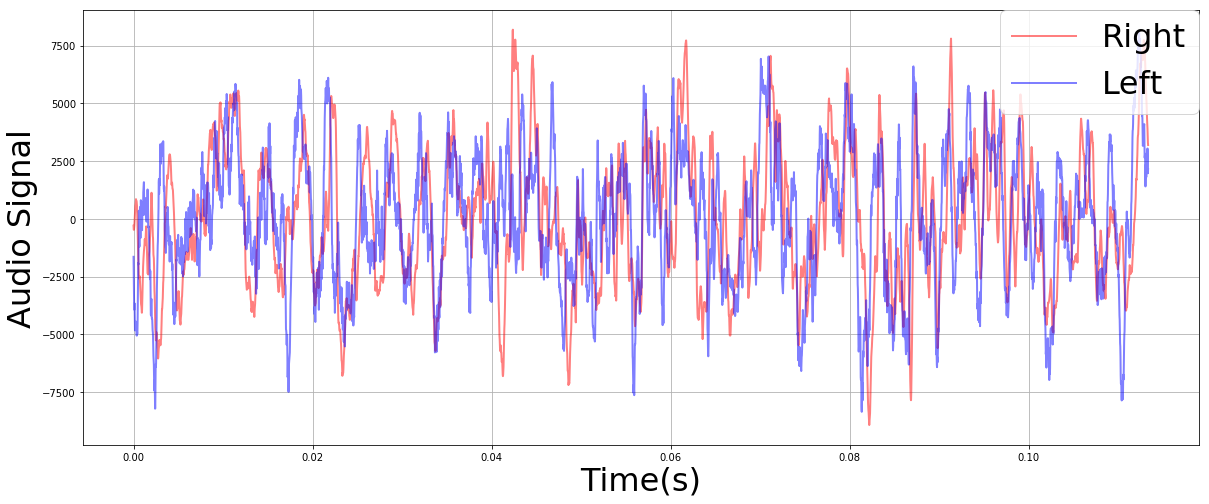

In [8]:
# 音声波形を確認する
%matplotlib inline

import matplotlib.pyplot as plt

endN = 5000 # 最初の endN 個までの波形を眺める
x = np.arange( endN ) * 1.0/audioSegment.frame_rate
plt.figure( figsize=(20, 8) )
plt.plot(x, r_sound[:endN:], linewidth=2, alpha=0.5, color="#ff0000", label='Right' )
plt.plot(x, l_sound[:endN:],  linewidth=2, alpha=0.5, color="#0000ff", label='Left' )
plt.grid(True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=32)
plt.xlabel("Time(s)",  fontsize=32)
plt.ylabel("Audio Signal",  fontsize=32)

In [10]:
w = 1000 # 短時間フーリエ変換の窓幅
s = 100    # （時間方向の）移動幅

r_amps = []; l_amps = [] # 左右の（周波数毎）振幅強度格納
n = r_sound.shape[0]    # 音声データ数

steps = int( ( n-w ) / s )
for i in range( steps ): # 時間移動しつつ窓付きFFTで（短時間フーリエ変換）
    f_r_sound = np.fft.fft( r_sound[ i*s: i*s+w ] )
    f_l_sound = np.fft.fft( l_sound[  i*s: i*s+w ] )

    # 左右チャンネル（の周波数振幅情報）に対して、
    # 重複情報は削除し、DC値の2倍分も補正しておく
    f_r_sound = f_r_sound[:int( w/2)];  f_r_sound[0] = f_r_sound[0]/2
    f_l_sound = f_l_sound[:int( w/2)];  f_l_sound[0] = f_l_sound[0]/2
    r_amps.append( np.abs(f_r_sound) )
    l_amps.append(  np.abs(f_l_sound) )

# スペクトログラムの周波数軸を生成
freq = np.fft.fftfreq( w, 1.0 / audioSegment.frame_rate )
freq = freq[:int(w/2) ]
# スペクトログラムの時間軸を生成
time = np.arange( steps ) * s / audioSegment.frame_rate

#numpyの配列にする
r_amps = np.array( r_amps )
l_amps = np.array( l_amps )

#print(r_amps.shape)
#print(freq.shape)

Text(0,0.5,'Amplitude')

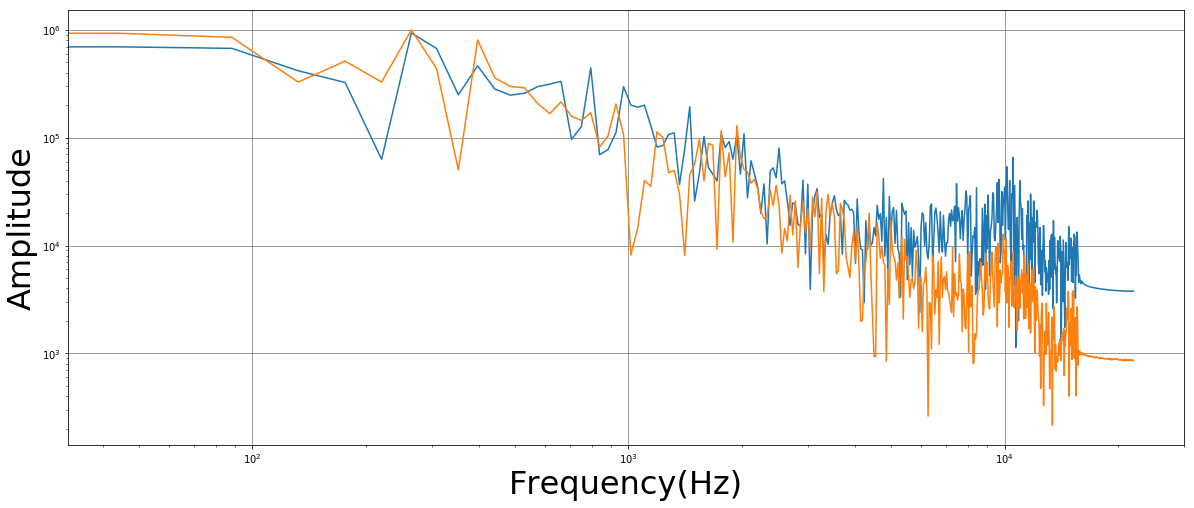

In [11]:
r_y = r_amps[1]
l_y = l_amps[1]

plt.figure( figsize=(20, 8) )
plt.plot(freq, l_y ); plt.plot(freq, r_y )
plt.yscale("log"); plt.xscale("log"); 
plt.grid(color='gray')
plt.xlabel("Frequency(Hz)", fontsize=32)
plt.ylabel("Amplitude", fontsize=32)

Text(33,0.5,'Amplitude at each Frequency')

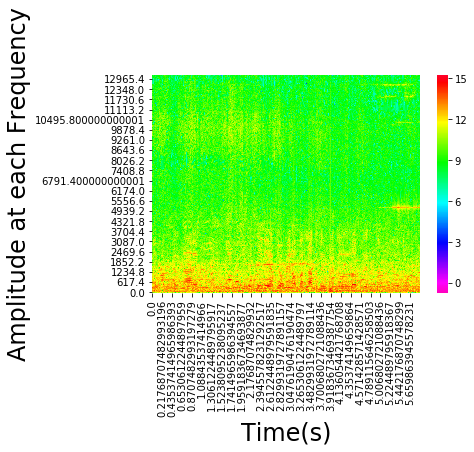

In [20]:
import pandas as pd
import seaborn as sns

pddfa = pd.DataFrame( data=l_amps, index=time, columns=freq )
ax = sns.heatmap( data=np.log( pddfa.iloc[:, :300].T ), 
            cmap=plt.cm.gist_rainbow_r ); ax.invert_yaxis()
plt.xlabel("Time(s)", fontsize=24)
plt.ylabel("Amplitude at each Frequency", fontsize=24)

Text(33,0.5,'Amplitude at each Frequency')

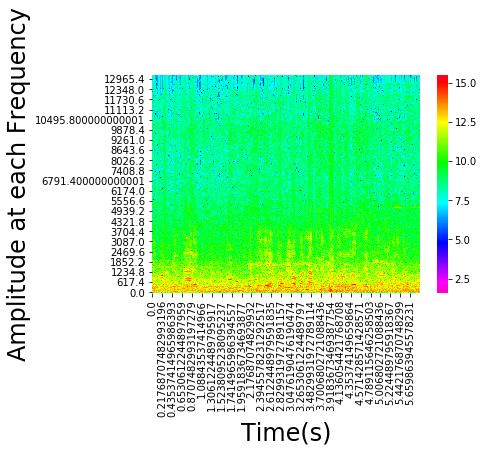

In [21]:
pddfa = pd.DataFrame( data=r_amps, index=time, columns=freq )
ax = sns.heatmap( data=np.log( pddfa.iloc[:, :300].T ), 
            cmap=plt.cm.gist_rainbow_r ); ax.invert_yaxis()
plt.xlabel("Time(s)", fontsize=24)
plt.ylabel("Amplitude at each Frequency", fontsize=24)

Text(50,0.5,'Amplitude of each Frequency')

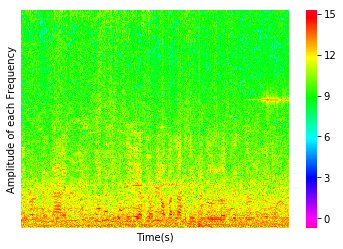

In [22]:
# 周波数空間で、左右位置を推定

positionNum = 1000
positionAve = positionNum/2
positions = []

for n in range( len( r_amps ) ): 
    pos = np.zeros( positionNum )
    for i in range( round(w/2) ):
        if r_amps[n][i] != 0 and l_amps[n][i] != 0:
            rl_ave = (r_amps[n][i] + l_amps[n][i])/2.0
            pos0 = r_amps[n][i] - l_amps[n][i]
            pos0 = 1.0 * positionAve * pos0/(2**15)/2.0+positionAve
            pos0 = int( np.clip( np.round( pos0 ), 0, positionNum-1) )
            if pos0 > 0 and pos0 < positionNum-1:
                pos[pos0] = pos[pos0]+rl_ave/(2**15)
    positions.append( pos )
pos = np.array(positions)

pddfa = pd.DataFrame( data=l_amps, index=time, columns=freq )
ax = sns.heatmap(
            data=np.log( pddfa.iloc[:, :200].T ), 
            xticklabels=-1, yticklabels=-1, 
            cmap=plt.cm.gist_rainbow_r
           )
ax.invert_yaxis()
plt.xlabel("Time(s)"); plt.ylabel("Amplitude of each Frequency")


Text(0,0.5,'Time')

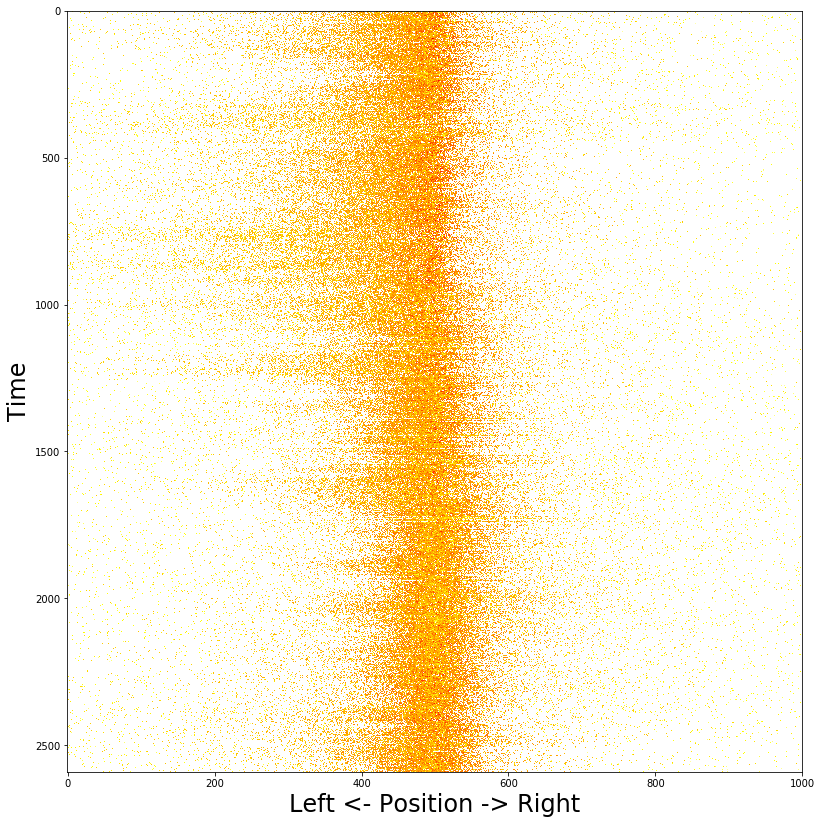

In [23]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(14, 14))
plt.imshow( pos, cmap='hot', norm=LogNorm(vmin=0.0001,vmax=100), aspect=0.4)
plt.xlabel("Left <- Position -> Right", fontsize=24)
plt.ylabel("Time", fontsize=24)

In [28]:
import cv2

cap = cv2.VideoCapture( '/Users/jun/Downloads/short.mp4' )
w = round( cap.get(cv2.CAP_PROP_FRAME_WIDTH) )
h = round( cap.get(cv2.CAP_PROP_FRAME_HEIGHT) )
frame_n = round( cap.get(cv2.CAP_PROP_FRAME_COUNT) )
fps = round( cap.get(cv2.CAP_PROP_FPS) )
cap.release()

In [165]:
cap = cv2.VideoCapture( '/Users/jun/Downloads/short.mp4' )
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter( '/Users/jun/Downloads/short.avi', fourcc, fps, (w,h) )

n = 0
while( cap.isOpened() ):
    ret, frame = cap.read()
    if ret:
        audiopos = int( np.clip( float(n) / frame_n * pos.shape[0], 0, pos.shape[0]-1) )
        heatImgLine = np.zeros( (h, w, 3), np.uint8 )
        heatImgFill = np.zeros( (h, w, 3), np.uint8 )
        for i in range( len( pos[ audiopos ] ) ):
            wpos = int( float(w) *  i / positionNum )
            heatImgLine = cv2.circle( heatImgLine, ( wpos, int(h/2) ) , 10*int(pos[ audiopos, i ]), (0, 0, 255), 2)
            heatImgFill = cv2.circle( heatImgFill, ( wpos, int(h/2) ) , 10*int(pos[ audiopos, i ]), (0, 0, 255), -1)
        frame = cv2.addWeighted( frame, 1.0, heatImgLine, 0.7, 1.0)
        frame = cv2.addWeighted( frame, 1.0, heatImgFill, 0.5, 1.0)
        out.write( frame )
        n = n+1
    else:
        break

cap.release()
out.release()

In [166]:
# OpenCVファイルと音声を結合

import moviepy.editor as mp

clip_output = mp.VideoFileClip('/Users/jun/Downloads/short.avi').subclip()
clip_output.write_videofile('/Users/jun/Downloads/short_vis.mp4', audio='/Users/jun/Downloads/short.mp3')

# 上記組み合わせだとOSXのQuicktime Playerでは音声が再生できないが、VLCでは再生できる

[MoviePy] >>>> Building video /Users/jun/Downloads/short_vis.mp4
[MoviePy] Writing video /Users/jun/Downloads/short_vis.mp4


 99%|█████████▉| 148/149 [00:02<00:00, 69.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/jun/Downloads/short_vis.mp4 

